In [186]:
import pandas as pd
import string
from collections import defaultdict
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# from google.colab import drive
# drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [187]:
# !pip install nltk==3.5
# !pip install numpy matplotlib

In [188]:
# Load Data
# 0 : Neg, 1 : Pos
train_df = pd.read_csv('/content/drive/MyDrive/자연어처리개론/train.tsv', sep = "\t")
test_df = pd.read_csv('/content/drive/MyDrive/자연어처리개론/dev.tsv', sep = "\t")

In [189]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_sentence(sentence):
    translator = str.maketrans('', '', string.punctuation)
    sentence = sentence.translate(translator)

    sentence = sentence.lower()

    tokens = word_tokenize(sentence)

    tokens = [word for word in tokens if word not in stop_words]

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return lemmatized_tokens

train_df['Tokenized_Sentence'] = train_df['sentence'].apply(preprocess_sentence)
test_df['Tokenized_Sentence'] = test_df['sentence'].apply(preprocess_sentence)

In [190]:
train_df.head()

,sentence,label,Tokenized_Sentence
0,hide new secretions from the parental units,0,"[hide, new, secretion, parental, unit]"
1,"contains no wit , only labored gags",0,"[contains, wit, labored, gag]"
2,that loves its characters and communicates som...,1,"[love, character, communicates, something, rat..."
3,remains utterly satisfied to remain the same t...,0,"[remains, utterly, satisfied, remain, throughout]"
4,on the worst revenge-of-the-nerds clichés the ...,0,"[worst, revengeofthenerds, clichés, filmmaker,..."


In [191]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sentence            67349 non-null  object
 1   label               67349 non-null  int64 
 2   Tokenized_Sentence  67349 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [192]:
test_df.head()

,sentence,label,Tokenized_Sentence
0,it 's a charming and often affecting journey .,1,"[charming, often, affecting, journey]"
1,unflinchingly bleak and desperate,0,"[unflinchingly, bleak, desperate]"
2,allows us to hope that nolan is poised to emba...,1,"[allows, u, hope, nolan, poised, embark, major..."
3,"the acting , costumes , music , cinematography...",1,"[acting, costume, music, cinematography, sound..."
4,"it 's slow -- very , very slow .",0,"[slow, slow]"


In [193]:
# Prior from training
def prior(df, sentiment = True):
  label_length = len(df['label'])
  # Positive
  if sentiment:
    return len(df[df['label'] == 1]) / label_length
  # Negative
  else:
    return len(df[df['label'] == 0]) / label_length

pos_prior = prior(train_df, sentiment = True)
neg_prior = prior(train_df, sentiment = False)
print(f"Positive Prior: {pos_prior}")
print(f"Negative Prior: {neg_prior}")

Positive Prior: 0.5578256544269403
Negative Prior: 0.44217434557305973


In [194]:
# Clear words from test/val that are not in the train
def filter_sentence(tokensized_sentence, train_df_words):
  return [word for word in tokensized_sentence if word in train_df_words]

def clear_words_test(train_df, test_df):
  train_df_words = list(set(word_tokenize(train_df['sentence'].to_string(index = False))))
  test_df['Tokenized_Sentence'] = test_df['Tokenized_Sentence'].apply(lambda x: filter_sentence(x, train_df_words))
  return test_df


test_df = clear_words_test(train_df, test_df)

test_df.head()

,sentence,label,Tokenized_Sentence
0,it 's a charming and often affecting journey .,1,"[charming, often, affecting, journey]"
1,unflinchingly bleak and desperate,0,"[bleak, desperate]"
2,allows us to hope that nolan is poised to emba...,1,"[allows, u, hope, nolan, major, career, commer..."
3,"the acting , costumes , music , cinematography...",1,"[acting, costume, music, cinematography, sound..."
4,"it 's slow -- very , very slow .",0,"[slow, slow]"


In [195]:
# Likelihoods from training

# size of Words |V|
def size_of_words(train_df):
  return len(set(word_tokenize(train_df['sentence'].to_string(index = False))))

norm_v = size_of_words(train_df)
print(f"Size of Words: {norm_v}")

# count(w, c)
def count_w_c(train_df):
  Neg_sentence = ''
  Pos_sentence = ''
  for sentence, label in zip(train_df['sentence'], train_df['label']):
    if label == 0:
      Neg_sentence += sentence
      Neg_sentence += ' '
    else:
      Pos_sentence += sentence
      Pos_sentence += ' '

  return len(word_tokenize(Neg_sentence)), len(word_tokenize(Pos_sentence))

count_denominator_neg, count_denominator_pos = count_w_c(train_df)
print(f"Count Denominator Neg: {count_denominator_neg}")
print(f"Count Denominator Pos: {count_denominator_pos}")

# count(w_i, c)
def count_w_i_c(train_df, test_df):
  for word_token in test_df['Tokenized_Sentence'][0]:
    print(word_token)


Size of Words: 17986
Count Denominator Neg: 294448
Count Denominator Pos: 339532


In [196]:
def cal_likelihood(train_df, test_df, norm_v, count_denominator_neg, count_denominator_pos):
    word_count_neg = defaultdict(int)
    word_count_pos = defaultdict(int)

    for _, row in train_df.iterrows():
        label = row['label']
        tokenized_sentence = row['Tokenized_Sentence']

        if label == 0:
            for token in tokenized_sentence:
                word_count_neg[token] += 1
        else:
            for token in tokenized_sentence:
                word_count_pos[token] += 1

    test_df['likelihood_neg'] = 0.0
    test_df['likelihood_pos'] = 0.0
    test_df['predict'] = 0

    for idx, row in test_df.iterrows():
        tokenized_sentence = row['Tokenized_Sentence']

        likelihood_neg = 1.0
        likelihood_pos = 1.0

        for token in tokenized_sentence:
            prob_neg = (word_count_neg[token] + 1) / (count_denominator_neg + norm_v)
            likelihood_neg *= prob_neg

            prob_pos = (word_count_pos[token] + 1) / (count_denominator_pos + norm_v)
            likelihood_pos *= prob_pos

        test_df.at[idx, 'likelihood_neg'] = likelihood_neg * neg_prior
        test_df.at[idx, 'likelihood_pos'] = likelihood_pos * pos_prior

        if likelihood_pos > likelihood_neg:
            test_df.at[idx, 'predict'] = 1
        else:
            test_df.at[idx, 'predict'] = 0

    return test_df

test_df = cal_likelihood(train_df, test_df, norm_v, count_denominator_neg, count_denominator_pos)


In [197]:
test_df = cal_likelihood(train_df, test_df, norm_v, count_denominator_neg, count_denominator_pos)

test_df.head()

,sentence,label,Tokenized_Sentence,likelihood_neg,likelihood_pos,predict
0,it 's a charming and often affecting journey .,1,"[charming, often, affecting, journey]",1.298584e-17,9.636207e-15,1
1,unflinchingly bleak and desperate,0,"[bleak, desperate]",2.581974e-09,3.054926e-10,0
2,allows us to hope that nolan is poised to emba...,1,"[allows, u, hope, nolan, major, career, commer...",4.109262e-41,3.388069e-38,1
3,"the acting , costumes , music , cinematography...",1,"[acting, costume, music, cinematography, sound...",2.507705e-37,6.923347e-35,1
4,"it 's slow -- very , very slow .",0,"[slow, slow]",5.784074e-08,5.655977e-09,0


In [198]:
# Accuracy
labels = test_df['label']
predictions = test_df['predict']

# 정확도 계산
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
conf_matrix = confusion_matrix(labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(labels, predictions))

Accuracy: 0.8028
Precision: 0.7731
Recall: 0.8671
F1 Score: 0.8174

Confusion Matrix:
[[315 113]
 [ 59 385]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       428
           1       0.77      0.87      0.82       444

    accuracy                           0.80       872
   macro avg       0.81      0.80      0.80       872
weighted avg       0.81      0.80      0.80       872



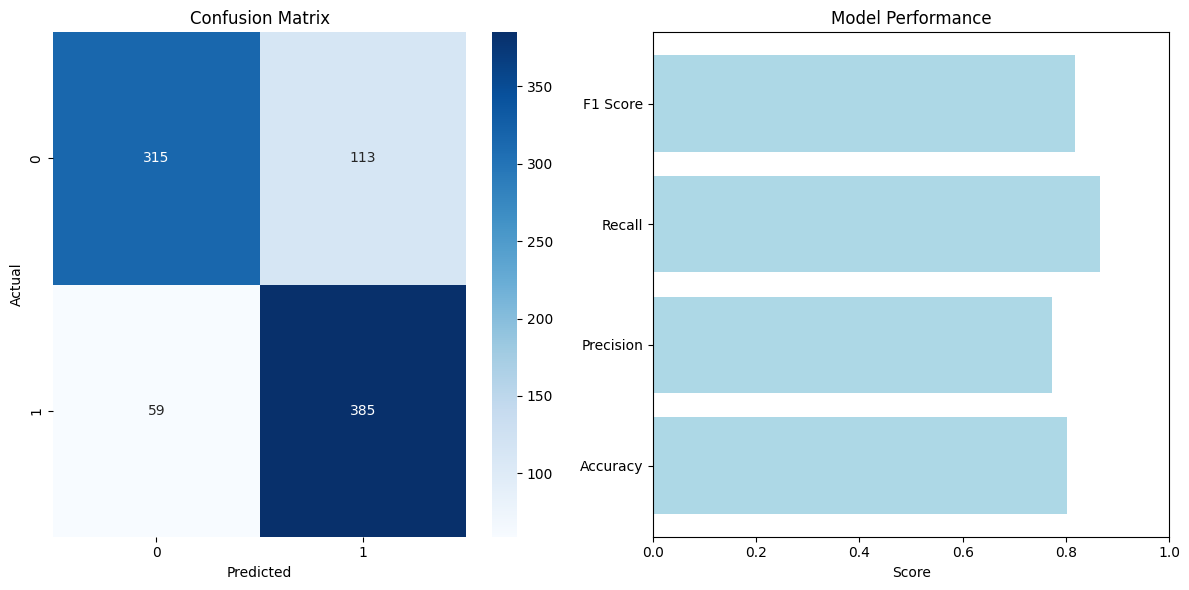

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

ax[1].barh(metrics, scores, color='lightblue')
ax[1].set_xlim(0, 1)
ax[1].set_title('Model Performance')
ax[1].set_xlabel('Score')

plt.tight_layout()

plt.savefig("model_performance_and_confusion_matrix1.png")

plt.show()
